# 2023 Immune dataset H3K27ac

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [86]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

In [87]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

## Load peaks

In [88]:
PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']
MODIFICATIONS = ['H3K27ac']

! mkdir -p {PATH}/pics

In [89]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr


In [90]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 2


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 2


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 2


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 2


file modification   cell  \
1  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K27ac  BCell   
0  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K27ac  TCell   
1  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
0  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac  TCell   
1  /home/jetbrains/data/2023_Immune/sicer/BCell_H...      H3K27ac  BCell   

    fdr  peaks     avlength         tool  
1   0.1  41460  1128.549445  MACS2 broad  
0  0.05  31192  2721.691267         SPAN  
1  0.05  26454  2055.782755         SPAN  
0   0.1  51740  1224.777812  MACS2 broad  
1  0.01  24342  3746.687125        SICER

In [91]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'DNAse']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

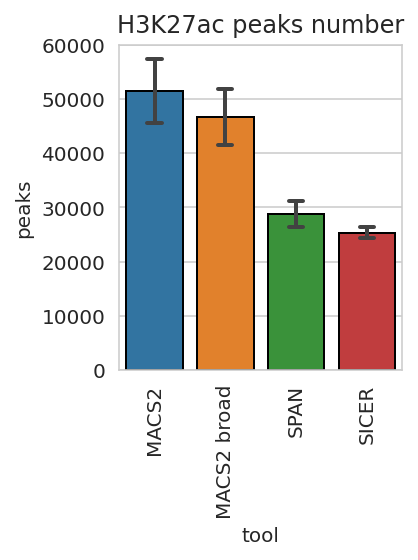

In [108]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(0, 60_000)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.show()

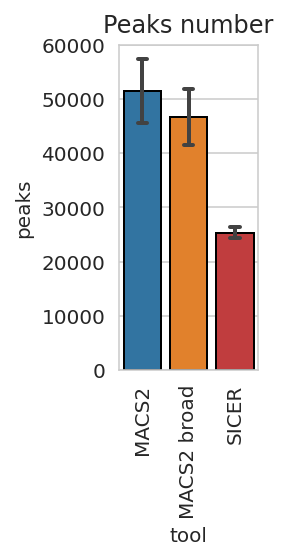

In [94]:
plt.figure(figsize=(2, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks number')
ax.set_ylim(0, 60_000)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [8]:
DNASE = {
    'BCell': PATH + '/dnaseq/BCell_DNAseq_hg38_ENCFF963BED.bed',
    'TCell': PATH + '/dnaseq/TCell_DNAseq_hg38_ENCFF762IIH.bed',
    'Monocyte': PATH + '/dnaseq/Monocyte_DNAseq_hg38_ENCFF087SET.bed',
}

for cell, dnase_file in DNASE.items():
    print(cell, lines(dnase_file))

BCell 117344
TCell 57323
Monocyte 123753


In [106]:
print('Load lengths')
ts = []
for cell, dnase_file in DNASE.items():
    t = pd.read_csv(dnase_file, sep='\t', header=None)
    t = t.sample(min(len(t), 10_000)).copy()
    t = pd.DataFrame(dict(length=t[2]-t[1]))    
    t['cell'] = cell
    t['name'] = 'DNAse'
    ts.append(t)
for cell, file, tool in tqdm(zip(df_fdr_peaks['cell'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length      cell         name
99846    2384     TCell         SPAN
3454      180     BCell        DNAse
41841    2264     BCell        MACS2
80244    3799     BCell        SICER
27044     110  Monocyte        DNAse
75181    2199     TCell        SICER
65605     758     BCell  MACS2 broad
2276      217     BCell        DNAse
68921     585     BCell  MACS2 broad
29497     151  Monocyte        DNAse

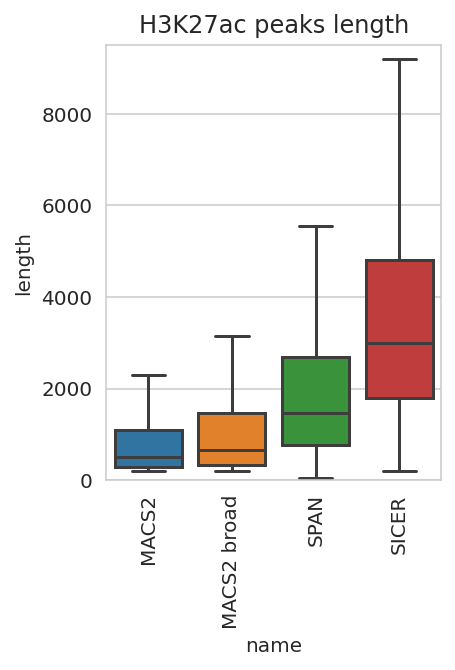

In [107]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 9_500])
plt.show()

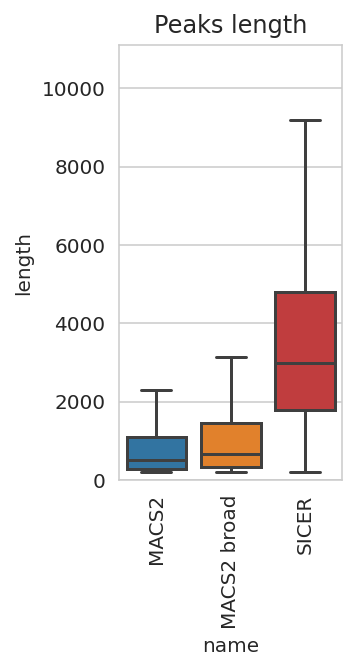

In [104]:
plt.figure(figsize=(2, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='name', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'],
                        showfliers=False)
ax.title.set_text('Peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 11_100])
plt.show()

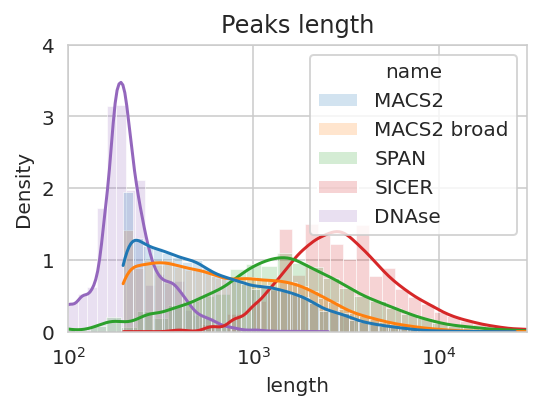

In [97]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=40, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'DNAse'])
g_results.set(xscale='log')
g_results.set_ylim(0, 4.0)
g_results.set_xlim(1e2, 3e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

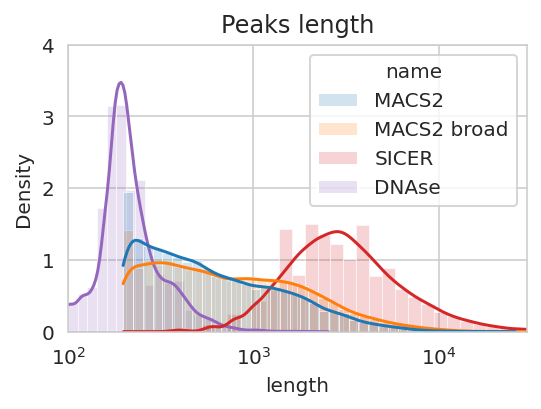

In [98]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=40, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'DNAse'])
g_results.set(xscale='log')
g_results.set_ylim(0, 4.0)
g_results.set_xlim(1e2, 3e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_lengths_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

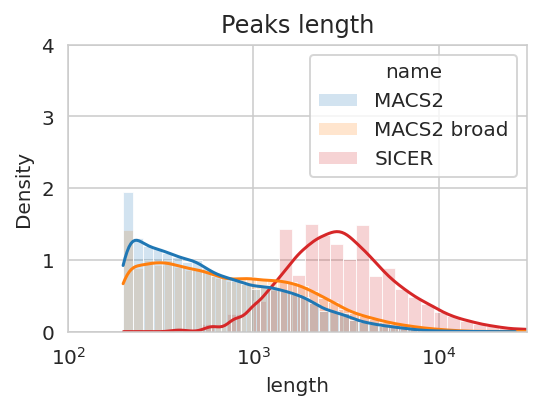

In [105]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=40, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER'])
g_results.set(xscale='log')
g_results.set_ylim(0, 4.0)
g_results.set_xlim(1e2, 3e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_lengths_nospan_nodnase.pdf', bbox_inches='tight', dpi=300)
plt.show()

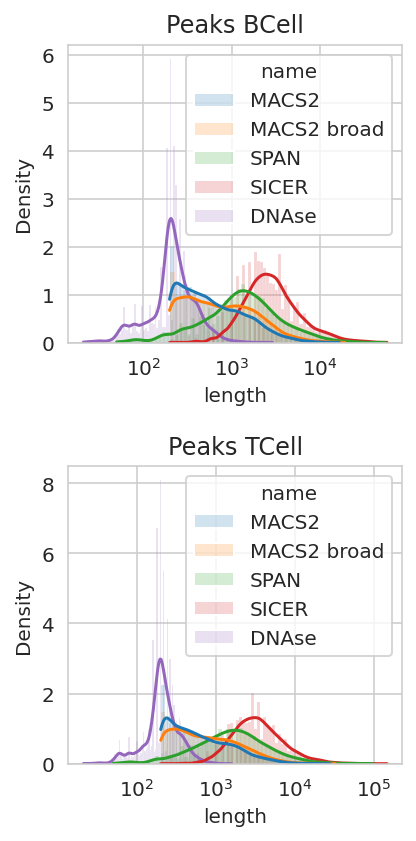

In [85]:
import math
experiments = [c for c in IMMUNE_CELLS if sum(t['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.histplot(data=t[t['cell'] == c],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(3)

0it [00:00, ?it/s]

tool   coverage
4  SICER  124149062
0  MACS2   55101554
5  SICER   91201858

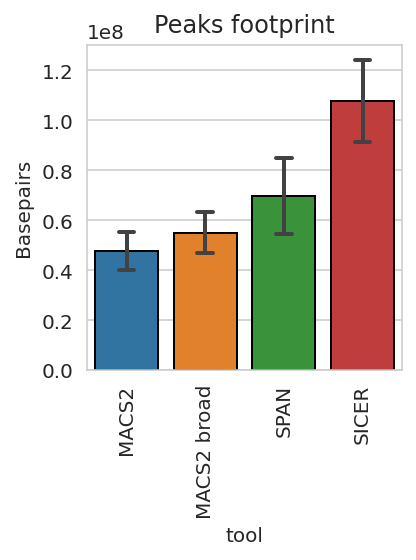

In [13]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between narrow and broad peaks

In [55]:
! mkdir -p {PATH}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'], dtype=object)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'length', 'tool', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K27ac') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{PATH}/union/H3K27ac_{c}.bed'        
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl['cell'] = c
            tl['length'] = percentage_name
            tl['name'] = 'SPAN'
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['cell'] = c
                tl['length'] = percentage_name
                tl['name'] = tool
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

                # print(tool)
                # ! wc -l {file}-perc
                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e) 

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


cell   length         tool  overlap_span_peaks  overlap_tool_peaks
3   BCell  20%-40%        MACS2                4554                6223
7   BCell  40%-60%  MACS2 broad                4819                6214
17  TCell   0%-20%        SICER                2235                2233

peak_lengths   cell   length         name
130448           339  TCell   0%-20%        MACS2
56366           1811  BCell  40%-60%  MACS2 broad
160465          1999  TCell  20%-40%        SICER

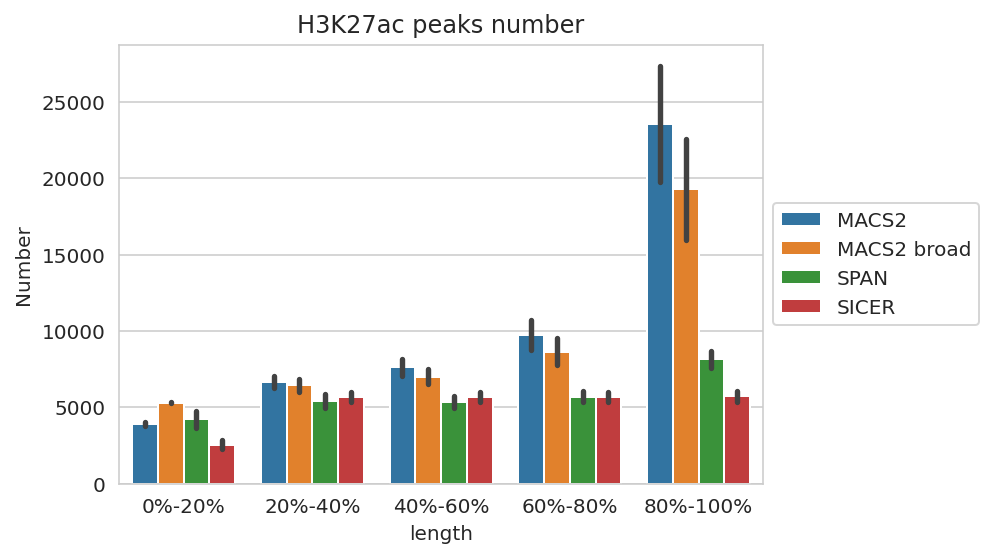

In [54]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


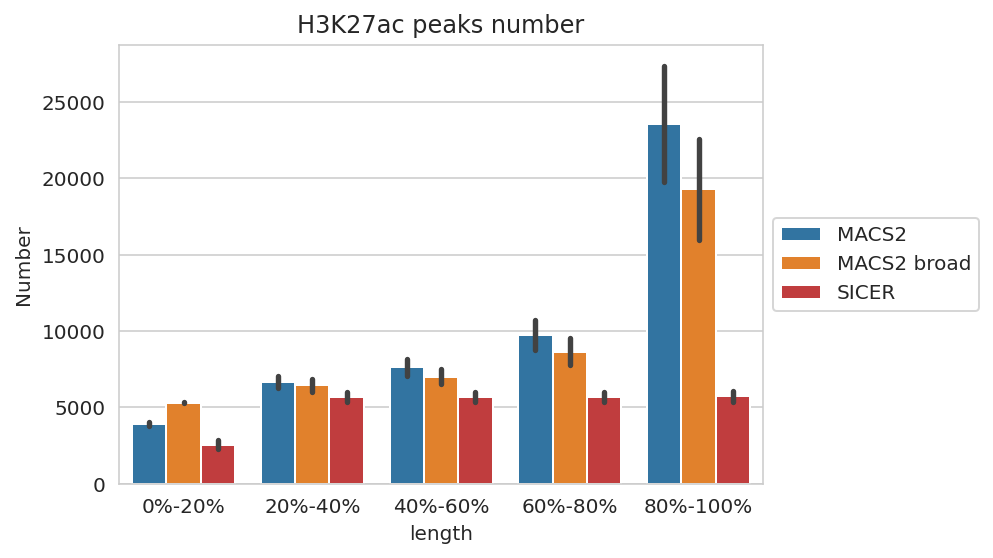

In [99]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peaks_percentile_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()


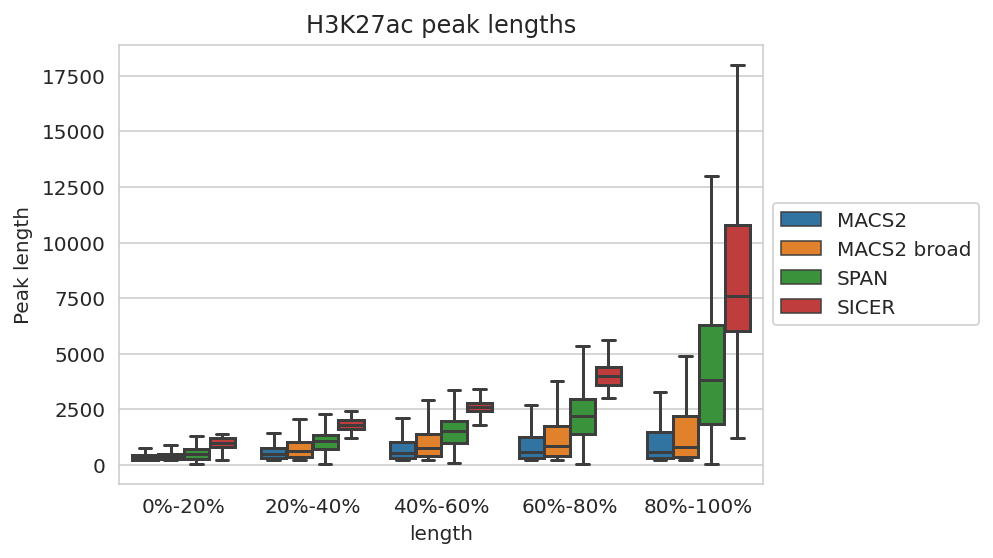

In [40]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()


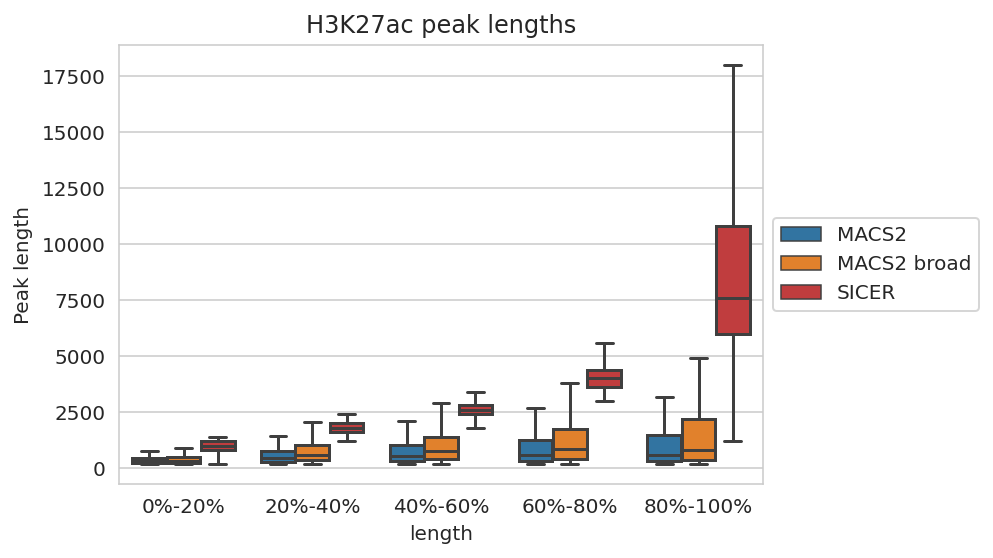

In [101]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peak_length_percentile_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()


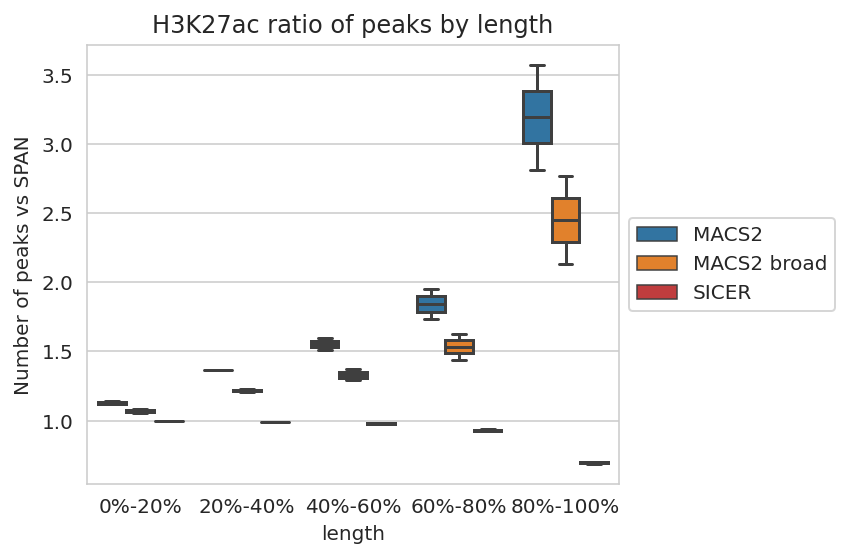

In [42]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K27ac vs DHS

In [67]:
import tempfile
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len', 'dnase', 'dnase_len',
             'peaks_overlap', 'peaks_overlap_len', 'dnase_overlap', 'dnase_overlap_len'],
    dtype=object
)


for c in tqdm(IMMUNE_CELLS):
    dnase_file = sorted_file(DNASE[c])
    dnase_peaks = lines(dnase_file)
    dnase_len = int(bedl(dnase_file).sum())
    print(f'Cell {c} dnase {dnase_peaks}')
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {dnase_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {dnase_file} -wa -u > {tf}
        dnase_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {dnase_file} -wo > {tf}
        peaks_overlap_len = dnase_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, tool,
                                       peaks, peaks_len,
                                       dnase_peaks, dnase_len,
                                       peaks_overlap, peaks_overlap_len,
                                       dnase_overlap, dnase_overlap_len)
bench_df

  0%|          | 0/2 [00:00<?, ?it/s]

Cell BCell dnase 117344
Cell TCell dnase 57323


cell         name  peaks  peaks_len   dnase  dnase_len  peaks_overlap  \
0  BCell         SPAN  26454   54383677  117344   29345832          22673   
1  BCell        MACS2  45626   40038619  117344   29345832          29971   
2  BCell        SICER  24342   91201858  117344   29345832          22377   
3  BCell  MACS2 broad  41460   46789660  117344   29345832          27885   
4  TCell         SPAN  31192   84894994   57323   13245939          18070   
5  TCell        MACS2  57350   55101554   57323   13245939          22977   
6  TCell        SICER  26338  124149062   57323   13245939          17545   
7  TCell  MACS2 broad  51740   63370004   57323   13245939          21110   

   peaks_overlap_len  dnase_overlap  dnase_overlap_len  
0           11906032          45623           11906032  
1            9495928          41398            9495928  
2           14092891          52712           14092891  
3           10687991          44621           10687991  
4            8239142          33349            8239142  
5            6767907          30814            6767907  
6            8770172          34910            8770172  
7            7229639          31857            7229639

In [68]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['dnase_overlap'], bench_df['dnase'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['dnase_overlap_len'], bench_df['dnase_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['dnase_len'], bench_df['dnase_overlap_len'])
]

In [69]:
# print('Ignore outliers')
# print(len(bench_df[bench_df['precision'] < 0.1]))
# bench_df = bench_df[bench_df['precision'] >= 0.1]

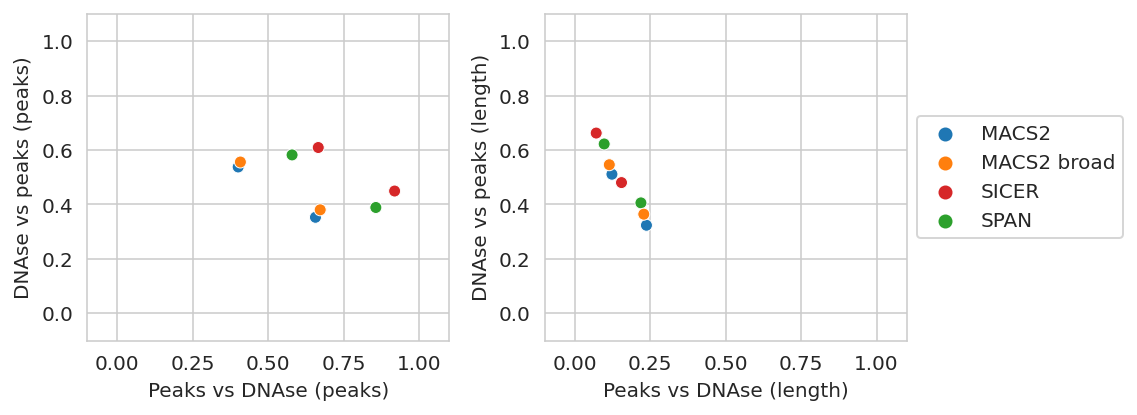

In [70]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax,
                            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'])
g_results.axes.set_xlabel('Peaks vs DNAse (peaks)')
g_results.axes.set_ylabel('DNAse vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax,
                            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'])
g_results.axes.set_xlabel('Peaks vs DNAse (length)')
g_results.axes.set_ylabel('DNAse vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [71]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
del ts

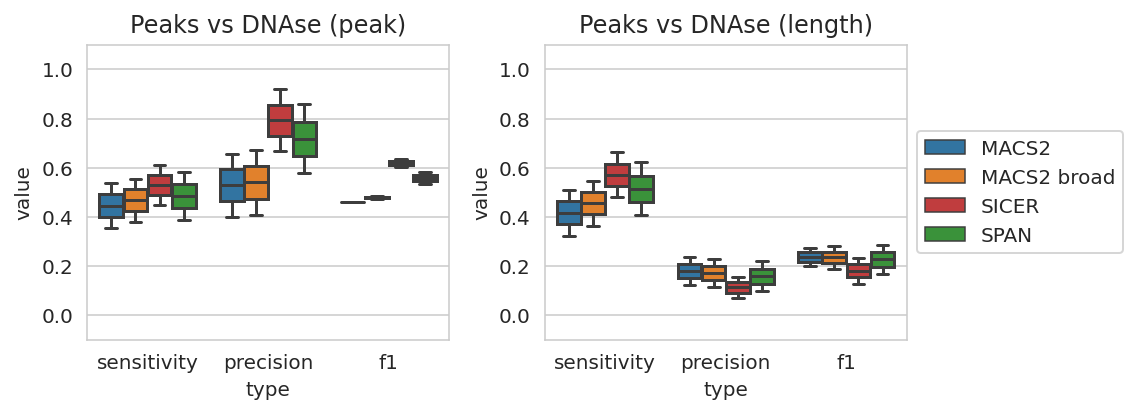

In [72]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name', palette=TOOLS_PALETTE,
                            ax=axs[i],
                            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'])

    ax = g_results.axes
    ax.set_title(f'Peaks vs DNAse ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K27ac diff vs DHS

In [73]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'name',
             'peaks', 'peaks_len', 'dnase', 'dnase_len',
             'peaks_overlap', 'peaks_overlap_len', 'dnase_overlap', 'dnase_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()


for c in tqdm(IMMUNE_CELLS):
    print(c)
    dnase_file = sorted_file(DNASE[c])
    dnase_peaks = lines(dnase_file)
    dnase_len = int(bedl(dnase_file).sum())
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K27ac') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {dnase_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {dnase_file} -wa -u > {tf2}
            dnase_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {dnase_file} -wo > {tf2}
            peaks_overlap_len = dnase_overlap_len = int(last_col(tf2).sum())
            diff_bench_df.loc[len(diff_bench_df)] = (c, name, peaks, peaks_len,
                                           dnase_peaks, dnase_len,
                                           peaks_overlap, peaks_overlap_len,
                                           dnase_overlap, dnase_overlap_len)

display(diff_bench_df.sample(5))

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


cell                name  peaks  peaks_len   dnase  dnase_len  \
2  BCell  SPAN - MACS2 broad   1108     558447  117344   29345832   
0  BCell        SPAN - MACS2   2315    1294506  117344   29345832   
4  BCell        SPAN - SICER    902     233135  117344   29345832   
5  BCell        SICER - SPAN   1514    3933486  117344   29345832   
8  TCell  SPAN - MACS2 broad   2567    1754732   57323   13245939   

   peaks_overlap  peaks_overlap_len  dnase_overlap  dnase_overlap_len  
2            462              88895            505              88895  
0           1123             232049           1265             232049  
4            398              48635            421              48635  
5            770             247453           1088             247453  
8            275              45589            299              45589

In [74]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['dnase_overlap'], diff_bench_df['dnase'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [
    d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])
]
diff_bench_df['sensitivity_len'] = [
    d(a, b) for a, b in zip(diff_bench_df['dnase_overlap_len'], diff_bench_df['dnase_len'])
]
diff_bench_df['f1_len'] = [
    d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])
]

diff_bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o
    in zip(diff_bench_df['peaks_len'], diff_bench_df['dnase_len'], diff_bench_df['dnase_overlap_len'])
]

In [75]:
full_bench_df = pd.concat([bench_df, diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell                name  peaks  peaks_len   dnase  dnase_len  \
3   BCell         MACS2 broad  41460   46789660  117344   29345832   
19  TCell        SICER - SPAN   1093    3774707   57323   13245939   
10  BCell  SPAN - MACS2 broad   1108     558447  117344   29345832   
0   BCell                SPAN  26454   54383677  117344   29345832   
17  TCell  MACS2 broad - SPAN   1738     453713   57323   13245939   

    peaks_overlap  peaks_overlap_len  dnase_overlap  dnase_overlap_len  \
3           27885           10687991          44621           10687991   
19            116              30491            151              30491   
10            462              88895            505              88895   
0           22673           11906032          45623           11906032   
17            143              16009            154              16009   

    precision  sensitivity        f1  precision_len  sensitivity_len  \
3    0.672576     0.380258  0.485836       0.228426         0.364208   
19   0.106130     0.002634  0.005141       0.008078         0.002302   
10   0.416968     0.004304  0.008519       0.159183         0.003029   
0    0.857073     0.388797  0.534931       0.218927         0.405715   
17   0.082278     0.002687  0.005203       0.035284         0.001209   

      f1_len   jaccard  
3   0.280762  0.163306  
19  0.003583  0.001795  
10  0.005945  0.002982  
0   0.284393  0.165768  
17  0.002337  0.001170

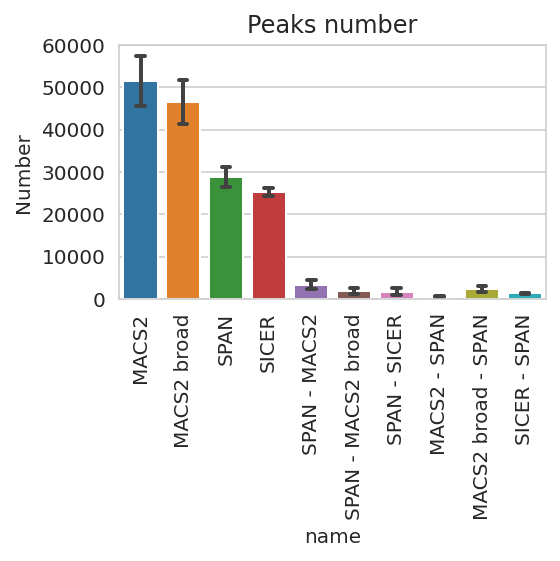

In [76]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(top=60_000)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

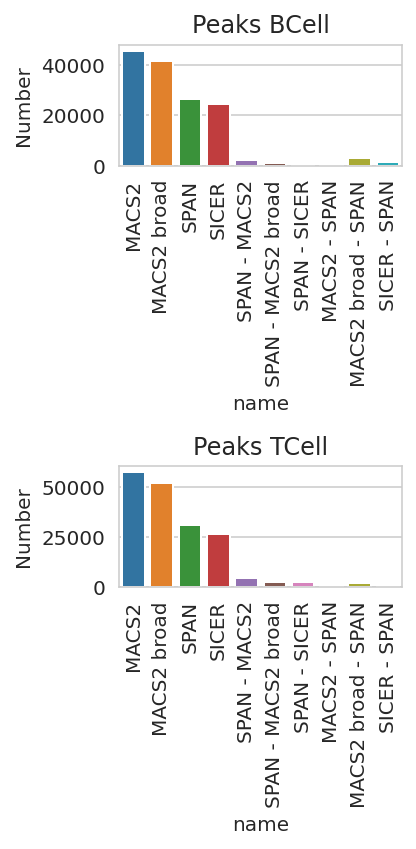

In [77]:
import math
experiments = [c for c in IMMUNE_CELLS
               if sum(full_bench_df['cell'] == c) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, c in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c}')
    g_results = sns.barplot(data=full_bench_df[full_bench_df['cell'] == c],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save benchmark

In [24]:
full_bench_df.to_csv(PATH + '/H3K27ac_full_bench_df.csv.gz', index=False, compression='gzip')

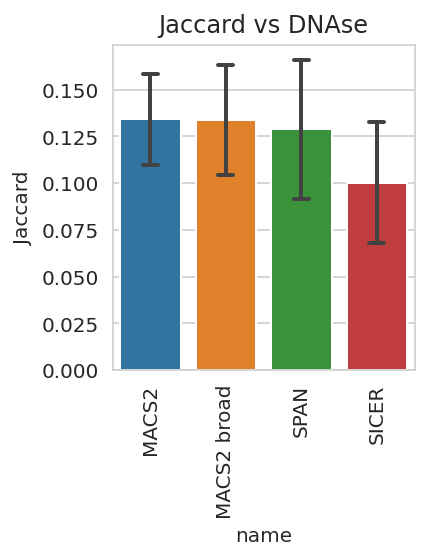

In [25]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs DNAse')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

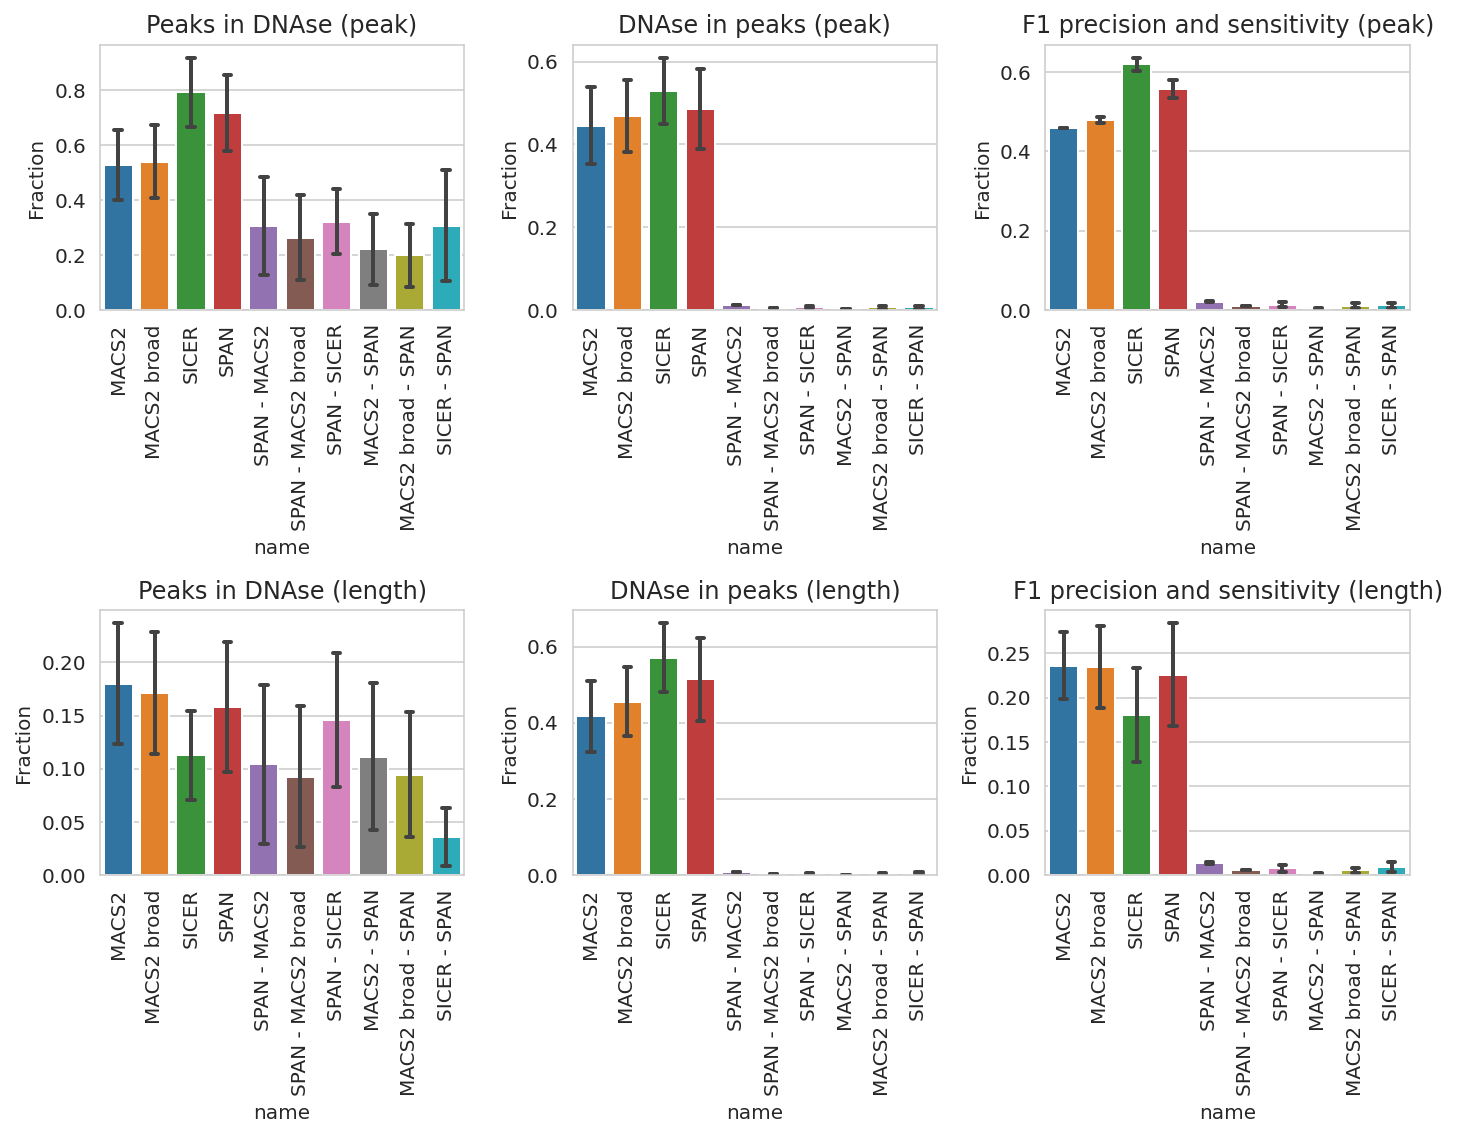

In [27]:
from itertools import product

plt.figure(figsize=(10, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in DNAse ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'DNAse in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

# Compare peaks to DNAse ratio

In [28]:
import tempfile

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'tool', 'dnase', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    dnase_file = sorted_file(DNASE[c])
    dnase_peaks = lines(dnase_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        dnase_cols = len(pd.read_csv(dnase_file, sep='\t', header=None, nrows=1).columns)
        !bedtools intersect -a {dnase_file} -b {peaks_file} -wa -wb > {tf}
        try:
            tf_overlap = pd.read_csv(tf, sep='\t', header=None)
            dnase_peaks = len(tf_overlap.groupby([0, 1, 2]).count())
            peaks = len(tf_overlap.groupby([dnase_cols, dnase_cols + 1, dnase_cols + 2]).count())
            ratio_df.loc[len(ratio_df)] = (c, tool, dnase_peaks, peaks)
        except:
            pass
ratio_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


cell         tool  dnase  peaks
0  BCell        SICER  52712  22377
1  BCell         SPAN  45623  22673
2  BCell  MACS2 broad  44621  27885
3  BCell        MACS2  41398  29971
4  TCell        SICER  34910  17545
5  TCell         SPAN  33349  18070
6  TCell  MACS2 broad  31857  21110
7  TCell        MACS2  30814  22977

In [29]:
ratio_df['dnase_to_peaks'] = ratio_df['dnase'] / ratio_df['peaks']
ratio_df.sort_values(by=['tool'], inplace=True)

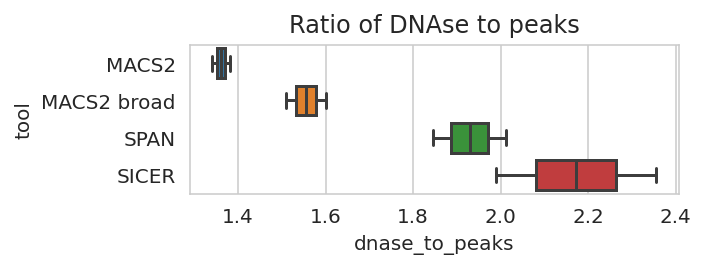

In [30]:
plt.figure(figsize=(5, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, x='dnase_to_peaks', y='tool', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.title.set_text('Ratio of DNAse to peaks')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_ratios.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Hg38 Top peaks overlap with DHS

In [31]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_top_df = pd.DataFrame(
    columns=['cell', 'top', 'dnase', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in DNASE:
        continue
    dnase_file = sorted_file(DNASE[c])
    dnase_peaks = lines(dnase_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15_000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {dnase_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {dnase_file} -wa -u > {tf2}
            dnase_overlap = lines(tf2)
            benchmark_top_df.loc[len(benchmark_top_df)] = \
                (c, top, dnase_peaks, peaks_file, peaks, peaks_overlap, dnase_overlap, tool)

benchmark_top_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


cell      top   dnase        peaks_file  peaks     pg     gp   tool
0    BCell   1000.0  117344  /tmp/tmpkw7qgxcz   1000    990   7276  SICER
1    BCell   2000.0  117344  /tmp/tmpkw7qgxcz   2000   1965  11756  SICER
2    BCell   3000.0  117344  /tmp/tmpkw7qgxcz   3000   2924  15295  SICER
3    BCell   4000.0  117344  /tmp/tmpkw7qgxcz   4000   3876  18329  SICER
4    BCell   5000.0  117344  /tmp/tmpkw7qgxcz   5000   4811  20954  SICER
..     ...      ...     ...               ...    ...    ...    ...    ...
115  TCell  11000.0   57323  /tmp/tmpgpcs4on5  11000  10139  17523  MACS2
116  TCell  12000.0   57323  /tmp/tmpgpcs4on5  12000  10913  18497  MACS2
117  TCell  13000.0   57323  /tmp/tmpgpcs4on5  13000  11674  19444  MACS2
118  TCell  14000.0   57323  /tmp/tmpgpcs4on5  14000  12387  20328  MACS2
119  TCell  15000.0   57323  /tmp/tmpgpcs4on5  15000  13080  21141  MACS2

[120 rows x 8 columns]

In [32]:
benchmark_top_df['p'] = (benchmark_top_df['pg'] + benchmark_top_df['gp']) / 2
benchmark_top_df['precision'] = [d(x, y) for x, y in zip(benchmark_top_df['pg'], benchmark_top_df['peaks'])]
benchmark_top_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_top_df['gp'], benchmark_top_df['dnase'])]
benchmark_top_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_top_df['sensitivity'], benchmark_top_df['precision'])]
benchmark_top_df

cell      top   dnase        peaks_file  peaks     pg     gp   tool  \
0    BCell   1000.0  117344  /tmp/tmpkw7qgxcz   1000    990   7276  SICER   
1    BCell   2000.0  117344  /tmp/tmpkw7qgxcz   2000   1965  11756  SICER   
2    BCell   3000.0  117344  /tmp/tmpkw7qgxcz   3000   2924  15295  SICER   
3    BCell   4000.0  117344  /tmp/tmpkw7qgxcz   4000   3876  18329  SICER   
4    BCell   5000.0  117344  /tmp/tmpkw7qgxcz   5000   4811  20954  SICER   
..     ...      ...     ...               ...    ...    ...    ...    ...   
115  TCell  11000.0   57323  /tmp/tmpgpcs4on5  11000  10139  17523  MACS2   
116  TCell  12000.0   57323  /tmp/tmpgpcs4on5  12000  10913  18497  MACS2   
117  TCell  13000.0   57323  /tmp/tmpgpcs4on5  13000  11674  19444  MACS2   
118  TCell  14000.0   57323  /tmp/tmpgpcs4on5  14000  12387  20328  MACS2   
119  TCell  15000.0   57323  /tmp/tmpgpcs4on5  15000  13080  21141  MACS2   

           p  precision  sensitivity        f1  
0     4133.0   0.990000     0.062006  0.116702  
1     6860.5   0.982500     0.100184  0.181827  
2     9109.5   0.974667     0.130343  0.229937  
3    11102.5   0.969000     0.156199  0.269031  
4    12882.5   0.962200     0.178569  0.301234  
..       ...        ...          ...       ...  
115  13831.0   0.921727     0.305689  0.459114  
116  14705.0   0.909417     0.322680  0.476344  
117  15559.0   0.898000     0.339201  0.492405  
118  16357.5   0.884786     0.354622  0.506314  
119  17110.5   0.872000     0.368805  0.518370  

[120 rows x 12 columns]

In [33]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [34]:
import plotly.graph_objects as go

def plot_top(benchmark_top_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_top_df[(benchmark_top_df['cell'] == c) &
                           (benchmark_top_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=PLOTLY_TOOLS_PALETTE[t],
            opacity=0.5,
        ))
        tools_legend_shown.add(t)


    fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping dnase (sensitivity)')
    fig.update_yaxes(range=[-0.1, 1.1], title='Dnase overlapping peaks (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()


In [35]:
plot_top(benchmark_top_df)

In [36]:
plot_top(benchmark_top_df[benchmark_top_df['cell'] == 'TCell'])

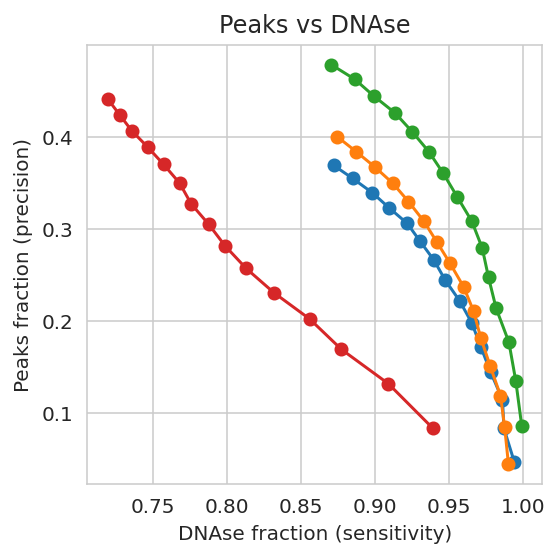

In [37]:
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    tt = benchmark_top_df[(benchmark_top_df['cell'] == 'TCell') &
                          (benchmark_top_df['tool'] == t)]
    plt.plot(tt['precision'], tt['sensitivity'], marker='o', label=t)
plt.title('Peaks vs DNAse')
plt.xlabel('DNAse fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_dnase.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [38]:
cells = []
reps = []
tools = []
aps = []
for c, t in tqdm(product(IMMUNE_CELLS, set(df_fdr_peaks['tool']))):
    dft = benchmark_top_df[(benchmark_top_df['cell'] == c) &
                           (benchmark_top_df['tool'] == t)].copy()
    if len(dft) == 0:
        continue
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev)*row['precision']
        rprev = row['sensitivity']
    cells.append(c)
    tools.append(t)
    aps.append(ap)
aps_df = pd.DataFrame(dict(cell=cells, tool=tools, ap=aps))

0it [00:00, ?it/s]

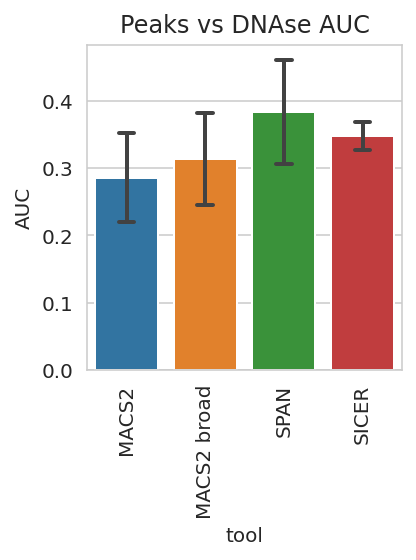

In [39]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs DNAse AUC')
g_results = sns.barplot(data=aps_df, x='tool', y='ap',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Functional annotation

In [40]:
import tempfile

tf = tempfile.mktemp()

! rm -r {PATH}/summary_H3K27ac
! mkdir -p {PATH}/summary_H3K27ac
print(f'{PATH}/summary_H3K27ac')

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{PATH}/summary_H3K27ac/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            !cat {tf} >> "{PATH}/summary_H3K27ac/{filename}.bed_"

for f in os.listdir(PATH + '/summary_H3K27ac'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{PATH}/summary_H3K27ac/{f}" | cut -f1-3 > "{PATH}/summary_H3K27ac/{f_sorted}"
    ! rm "{PATH}/summary_H3K27ac/{f}"

/home/jetbrains/data/2023_Immune/summary_H3K27ac


  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


# Coverage

In [57]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = PATH + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [58]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K27ac')
display(bws_df.sample(2))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(2))

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell
1  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...      H3K27ac  BCell
0  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...      H3K27ac  TCell

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell
0  /home/jetbrains/data/2023_Immune/bw/TCell_Cont...      Control  TCell
1  /home/jetbrains/data/2023_Immune/bw/BCell_Cont...      Control  BCell

In [59]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [60]:
import tempfile
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[bws_control_df['cell'] == c]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(
                bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]))
        frip_df.loc[len(frip_df)] = (c, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)
frip_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
SPAN /tmp/tmpcc2461e2 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 /tmp/tmp4_ji2cm7 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
SICER /tmp/tmpmylmqbl1 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
MACS2 broad /tmp/tmp1mwd2oc7 /home/jetbrains/data/2023_Immune/bw/BCell_H3K27ac_hg38_ENCFF404HKA.bw /home/jetbrains/data/2023_Immune/bw/BCell_Control_hg38_ENCFF198QJK.bw
TCell
SPAN /tmp/tmp1sabchsh /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
MACS2 /tmp/tmpzeeulagd /home/jetbrains/data/2023_Immune/bw/TCell_H3K27ac_hg38_ENCFF530DQB.bw /home/jetbrains/data/2023_Immune/bw/TCell_Control_hg38_ENCFF566HDE.bw
SICER 

cell                                            bw_file         tool  \
0  BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...         SPAN   
1  BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...        MACS2   
2  BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...        SICER   
3  BCell  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...  MACS2 broad   
4  TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...         SPAN   
5  TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...        MACS2   
6  TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...        SICER   
7  TCell  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...  MACS2 broad   

         peaks_file  peaks     length  reads_in_peaks     all_reads  \
0  /tmp/tmpcc2461e2  26454   54383677    2.892561e+07  8.491408e+07   
1  /tmp/tmp4_ji2cm7  45626   40038619    2.707811e+07  8.488214e+07   
2  /tmp/tmpmylmqbl1  24342   91201858    3.183621e+07  8.488214e+07   
3  /tmp/tmp1mwd2oc7  41460   46789660    2.813385e+07  8.488214e+07   
4  /tmp/tmp1sabchsh  31192   84894994    2.916089e+07  8.490978e+07   
5  /tmp/tmpzeeulagd  57350   55101554    2.620481e+07  8.490978e+07   
6  /tmp/tmp1y0wok_4  26338  124149062    3.162848e+07  8.488773e+07   
7  /tmp/tmplxk1vul8  51740   63370004    2.727039e+07  8.490978e+07   

   control_reads_in_peaks  control_all_reads  
0            2.275276e+06       8.490550e+07  
1            1.582062e+06       8.483880e+07  
2            3.651144e+06       8.481521e+07  
3            1.834033e+06       8.483880e+07  
4            3.278291e+06       8.491418e+07  
5            2.099982e+06       8.488194e+07  
6            4.700284e+06       8.482415e+07  
7            2.409780e+06       8.488194e+07

In [61]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / (z / 1e3)) / (y / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / z) / ((y - x) / (sum(CHROM_SIZES.values()) - z)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / (y / 1e6), z / (u / 1e6)))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

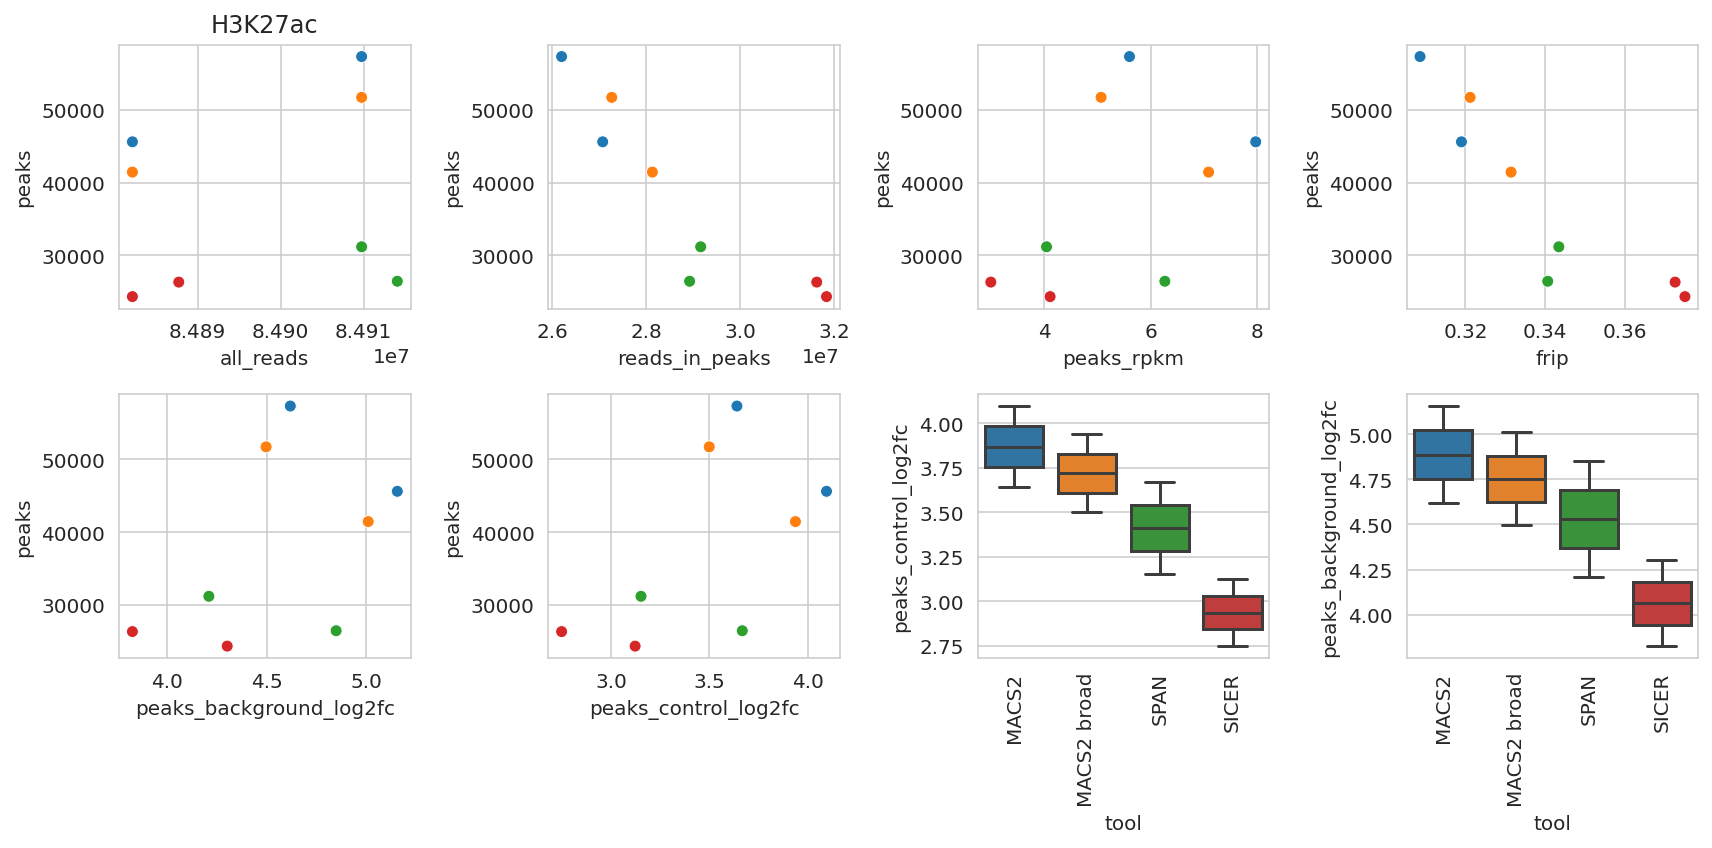

In [64]:
import seaborn as sns

t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27ac')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{PATH}/pics/H3K27ac_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [65]:
frip_df.to_csv(f'{PATH}/pics/H3K27ac_frip.csv.gz', index=None, compression='gzip')

## Density Peaks

In [13]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = bws_df[(bws_df['modification'] == 'H3K27ac') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


modification   cell         name                   position  length  \
166390      H3K27ac  BCell         SPAN    chr15:65663018-65663700     682   
32614       H3K27ac  BCell  MACS2 broad     chr6:26532062-26533680    1618   
387290      H3K27ac  TCell  MACS2 broad     chr6:11381146-11383682    2536   
200341      H3K27ac  BCell        MACS2    chr16:27318115-27318861     746   
524223      H3K27ac  TCell        MACS2  chr11:134223942-134224566     624   

             type    coverage  total_coverage  
166390    control  127.232974    8.490550e+07  
32614   treatment  498.198362    8.488214e+07  
387290    control   25.473140    8.488194e+07  
200341  treatment  141.399898    8.488214e+07  
524223  treatment  766.450399    8.490978e+07

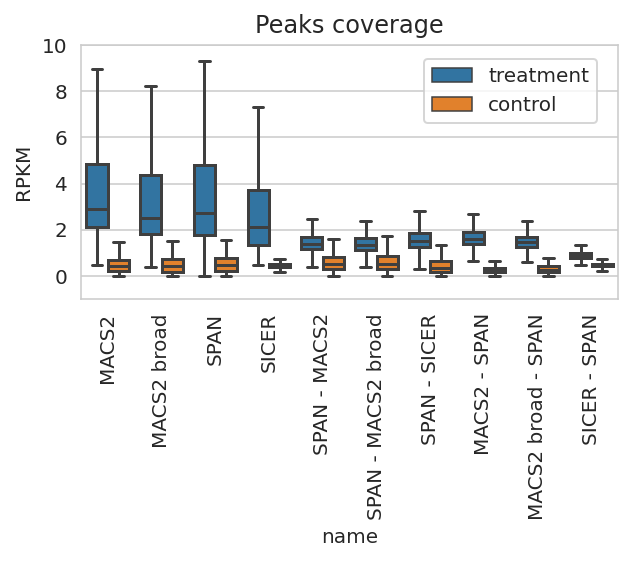

In [14]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 10)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [49]:
CHROMHMM_MAP = {
    'BCell': PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [50]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

  0%|          | 0/2 [00:00<?, ?it/s]

BCell
TCell


cell                name  peaks  EnhA1  EnhA2  EnhBiv  EnhG1  EnhG2  \
0   BCell               SICER  24342  13590   4666     400   2968   1576   
1   BCell                SPAN  26454  14832   4808     153   2114   1679   
2   BCell         MACS2 broad  41460  19974   6424     221   2798   2209   
3   BCell               MACS2  45626  24069   6428     152   2108   2738   
4   BCell        SPAN - MACS2   2315    345    215      16    195     16   
5   BCell        MACS2 - SPAN    704     68     43       7     54      2   
6   BCell  SPAN - MACS2 broad   1108     93     85       8     87      3   
7   BCell  MACS2 broad - SPAN   2974    134    142      46    258     13   
8   BCell        SPAN - SICER    902     86     39      10     51      1   
9   BCell        SICER - SPAN   1514     46     60      11    156      2   
10  TCell               SICER  26338  15461   5870    1294   4036   2066   
11  TCell                SPAN  31192  16801   6169     905   3807   2244   
12  TCell         MACS2 broad  51740  24268   8097     932   5052   3570   
13  TCell               MACS2  57350  29886   7739     761   4012   4688   
14  TCell        SPAN - MACS2   4514    323    320     103    477      6   
15  TCell        MACS2 - SPAN    456      9     34      21     34      1   
16  TCell  SPAN - MACS2 broad   2567     90    167      44    244      3   
17  TCell  MACS2 broad - SPAN   1738     29     82      69    121      1   
18  TCell        SPAN - SICER   2556    216    160     141    124      2   
19  TCell        SICER - SPAN   1093      5     19      25    119      0   

    EnhWk  Het  ...  ReprPC  ReprPCWk   TssA  TssBiv  TssFlnk  TssFlnkD  \
0   18663  776  ...    1345      1299   8426     396    12592      7518   
1   13773  184  ...     161       156   8554     307    13009      5515   
2   18293  224  ...     245       235   9756     398    16713      6524   
3   13268  111  ...     113       107  11329     346    18792      5480   
4    1310   30  ...      17        16     33      30      252       205   
5     293    6  ...      12        12     15      22      125        98   
6     607   15  ...       5         5     11      13       98        77   
7    1314   45  ...      64        61     33      58      445       354   
8     313   11  ...      10         9     34      28      218       135   
9     939   64  ...      49        47      9      11      129       119   
10  19418  271  ...    3466      3318   8370    1191    13970      7293   
11  18289  112  ...    1077      1023   8518    1201    14813      6537   
12  22526   90  ...     779       720   9922    1364    19619      6657   
13  17710   54  ...     424       386  11518    1286    22308      6059   
14   2088   18  ...     172       166     27     109      349       284   
15    135    0  ...      20        19      3      24       54        40   
16   1132    7  ...     101        96     16      49      181       154   
17    531   10  ...      84        76      5      79      141       107   
18   1003   12  ...     141       127     42     165      381       260   
19    382   15  ...      33        30      0      17       43        38   

    TssFlnkU     Tx   TxWk  ZNF_Rpts  
0      11211  10488   9565         0  
1      11649   3564   3172         0  
2      13684   3919   3340         0  
3      15916   2193   1934         0  
4         40    473    373         0  
5         18    107     73         0  
6          8    246    186         0  
7         27    578    392         0  
8         38     77     49         0  
9          9    854    717         0  
10     12776  13882  12151         0  
11     13346   8474   6762         0  
12     16822   6802   5116         0  
13     19371   3700   2899         0  
14        37   1852   1177         0  
15         9    139     82         0  
16        10   1116    694         0  
17        14    653    386         0  
18        70    533    340         0  
19         0    851    600         0  

[20 rows x 2

In [51]:
chrommm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
chrommm_df_mean

EnhA1   EnhA2  EnhBiv   EnhG1   EnhG2    EnhWk    Het  \
name                                                                          
MACS2               26977.5  7083.5   456.5  3060.0  3713.0  15489.0   82.5   
MACS2 broad         22121.0  7260.5   576.5  3925.0  2889.5  20409.5  157.0   
SPAN                15816.5  5488.5   529.0  2960.5  1961.5  16031.0  148.0   
SICER               14525.5  5268.0   847.0  3502.0  1821.0  19040.5  523.5   
SPAN - MACS2          334.0   267.5    59.5   336.0    11.0   1699.0   24.0   
SPAN - MACS2 broad     91.5   126.0    26.0   165.5     3.0    869.5   11.0   
SPAN - SICER          151.0    99.5    75.5    87.5     1.5    658.0   11.5   
MACS2 - SPAN           38.5    38.5    14.0    44.0     1.5    214.0    3.0   
MACS2 broad - SPAN     81.5   112.0    57.5   189.5     7.0    922.5   27.5   
SICER - SPAN           25.5    39.5    18.0   137.5     1.0    660.5   39.5   

                     Quies  ReprPC  ReprPCWk     TssA  TssBiv  TssFlnk  \
name                                                                     
MACS2               1955.5   268.5     246.5  11423.5   816.0  20550.0   
MACS2 broad         3097.5   512.0     477.5   9839.0   881.0  18166.0   
SPAN                3229.5   619.0     589.5   8536.0   754.0  13911.0   
SICER               8010.5  2405.5    2308.5   8398.0   793.5  13281.0   
SPAN - MACS2         414.0    94.5      91.0     30.0    69.5    300.5   
SPAN - MACS2 broad   237.5    53.0      50.5     13.5    31.0    139.5   
SPAN - SICER         245.0    75.5      68.0     38.0    96.5    299.5   
MACS2 - SPAN          66.5    16.0      15.5      9.0    23.0     89.5   
MACS2 broad - SPAN   327.0    74.0      68.5     19.0    68.5    293.0   
SICER - SPAN         368.5    41.0      38.5      4.5    14.0     86.0   

                    TssFlnkD  TssFlnkU       Tx     TxWk  ZNF_Rpts  
name                                                                
MACS2                 5769.5   17643.5   2946.5   2416.5       0.0  
MACS2 broad           6590.5   15253.0   5360.5   4228.0       0.0  
SPAN                  6026.0   12497.5   6019.0   4967.0       0.0  
SICER                 7405.5   11993.5  12185.0  10858.0       0.0  
SPAN - MACS2           244.5      38.5   1162.5    775.0       0.0  
SPAN - MACS2 broad     115.5       9.0    681.0    440.0       0.0  
SPAN - SICER           197.5      54.0    305.0    194.5       0.0  
MACS2 - SPAN            69.0      13.5    123.0     77.5       0.0  
MACS2 broad - SPAN     230.5      20.5    615.5    389.0       0.0  
SICER - SPAN            78.5       4.5    852.5    658.5       0.0

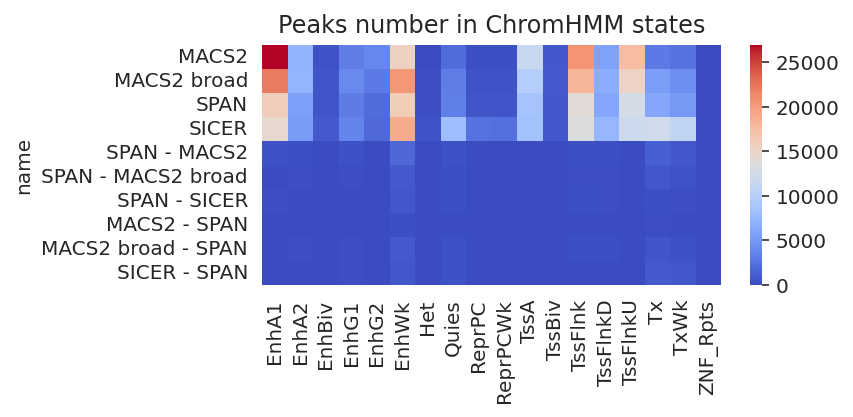

In [52]:
plt.figure(figsize=(6, 3))
sns.heatmap(chrommm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [53]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.524322  0.137914  0.008300  0.058079  0.070877   
MACS2 broad         0.475402  0.155719  0.011672  0.082564  0.061140   
SPAN                0.549652  0.189762  0.017399  0.100981  0.067705   
SICER               0.572658  0.207279  0.032782  0.137584  0.071593   
SPAN - MACS2        0.110292  0.081882  0.014865  0.094952  0.004120   
SPAN - MACS2 broad  0.059498  0.070886  0.012180  0.086786  0.001938   
SPAN - SICER        0.089925  0.052918  0.033125  0.052527  0.000946   
MACS2 - SPAN        0.058164  0.067820  0.027998  0.075633  0.002517   
MACS2 broad - SPAN  0.030872  0.047464  0.027584  0.078186  0.002473   
SICER - SPAN        0.017479  0.028507  0.015069  0.105956  0.000661   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.299802  0.001687  0.037993  0.004935  0.004538   
MACS2 broad         0.438295  0.003571  0.066645  0.010483  0.009792   
SPAN                0.553488  0.005273  0.110194  0.020307  0.019347   
SICER               0.751981  0.021084  0.315906  0.093426  0.089671   
SPAN - MACS2        0.514218  0.008473  0.119492  0.022724  0.021843   
SPAN - MACS2 broad  0.494408  0.008132  0.127659  0.021929  0.020955   
SPAN - SICER        0.369708  0.008445  0.137463  0.033125  0.029832   
MACS2 - SPAN        0.356123  0.004261  0.115318  0.030453  0.029356   
MACS2 broad - SPAN  0.373676  0.010442  0.136616  0.034926  0.032120   
SICER - SPAN        0.484854  0.027998  0.272652  0.031278  0.029245   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.224569  0.015004  0.400425  0.112878  0.343302   
MACS2 broad         0.213539  0.017981  0.391148  0.143010  0.327589   
SPAN                0.298218  0.025054  0.483328  0.209024  0.434108   
SICER               0.331971  0.030744  0.523854  0.292875  0.472820   
SPAN - MACS2        0.010118  0.018553  0.093085  0.075734  0.012738   
SPAN - MACS2 broad  0.008080  0.015411  0.079479  0.064743  0.005558   
SPAN - SICER        0.027063  0.047798  0.195373  0.125694  0.034758   
MACS2 - SPAN        0.013943  0.041941  0.147989  0.113462  0.022653   
MACS2 broad - SPAN  0.006987  0.032478  0.115379  0.090298  0.008567   
SICER - SPAN        0.002972  0.011410  0.062273  0.056683  0.002972   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.056290  0.046469       0.0  
MACS2 broad         0.112995  0.089719       0.0  
SPAN                0.203198  0.168346       0.0  
SICER               0.478966  0.427145       0.0  
SPAN - MACS2        0.307299  0.210934       0.0  
SPAN - MACS2 broad  0.328385  0.219112       0.0  
SPAN - SICER        0.146947  0.093672       0.0  
MACS2 - SPAN        0.228407  0.141759       0.0  
MACS2 broad - SPAN  0.285035  0.176952       0.0  
SICER - SPAN        0.671330  0.511264       0.0

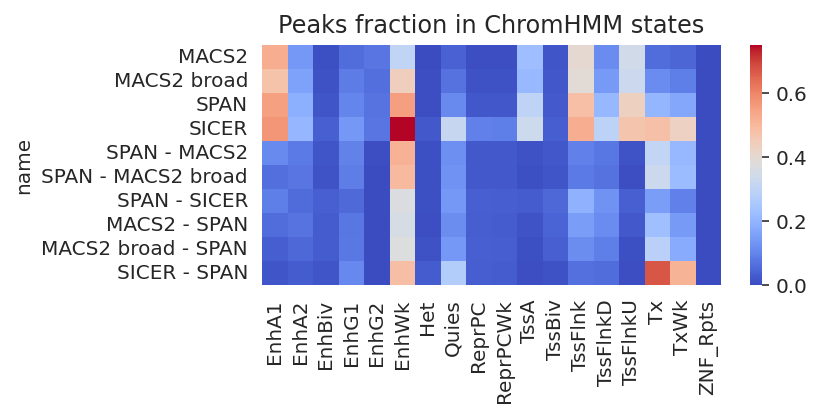

In [54]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27ac_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()